# DeepFace Analysis

In [1]:
import itertools
import json
import os
from pprint import pprint
import tempfile
from typing import List, Optional, Tuple

from tqdm import tqdm

import cv2 as cv
import numpy as np
from sklearn import metrics

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

In [9]:
backend = 'mtcnn'
predictions_path = os.path.join('../images/processed', f'deepface_{backend}.json')

with open(predictions_path, 'r') as fp:
    predictions = json.load(fp)
    
pprint(f'Predictions for {len(predictions)} images')

'Predictions for 24 images'


In [10]:
images_root = '../images/raw'

via_project_path = os.path.join(images_root, 'via_project_13Sep2022_19h41m.json')

In [11]:
with open(via_project_path, 'r') as f:
    via_project = json.load(f)
    
via_images = via_project['_via_image_id_list']
via_metadata = via_project['_via_img_metadata']

In [12]:
via_img = via_images[0]
img_metadata = via_metadata[via_img]

img_path = os.path.join(images_root, img_metadata['filename'])
img_regions = img_metadata['regions']
print(f'Image annotations: {img_path}')
pprint(img_metadata)

Image annotations: ../images/raw\vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png
{'file_attributes': {'height': '512', 'width': '512'},
 'filename': 'vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png',
 'regions': [{'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 175,
                                   'name': 'rect',
                                   'width': 134,
                                   'x': 66,
                                   'y': 21}},
             {'region_attributes': {'gender': 'Man'},
              'shape_attributes': {'height': 124,
                                   'name': 'rect',
                                   'width': 93,
                                   'x': 338,
                                   'y': 43}},
             {'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 187,
                                   'name': 'rect',
           

In [16]:
def region_bbox(region: dict) -> List[int]:
    shape = region['shape_attributes']
    bbox = [
        shape['x'],
        shape['y'],
        shape['x'] + shape['width'],
        shape['y'] + shape['height']
    ]
    return bbox

In [17]:
def image_size(img_metadata: dict) -> Tuple[int, int]:
    width = int(img_metadata['file_attributes']['width'])
    height = int(img_metadata['file_attributes']['height'])
    return (width, height)

def region_labels(region: dict) -> dict:
    labels = region['region_attributes'].copy()
    labels['bbox'] = region_bbox(region)
    return labels

def image_labels(img_metadata: dict) -> List[Optional[dict]]:
    width, height = image_size(img_metadata)
    quadrants = sort_regions((width, height), img_metadata['regions'])
    labels = [region_labels(region) if region else None for region in quadrants] 
    return {
        'filename': img_metadata['filename'],
        'labels': labels
    }

def project_labels(via_project: dict) -> List[Tuple[str, List[Optional[dict]]]]:
    img_metadata = via_project['_via_img_metadata']
    return list(map(lambda id: image_labels(img_metadata[id]), via_project['_via_image_id_list']))

In [18]:
labels = project_labels(via_project)
pprint(labels[:5])

[{'filename': 'vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png',
  'labels': [{'bbox': [66, 21, 200, 196], 'gender': 'Woman'},
             {'bbox': [47, 257, 200, 444], 'gender': 'Woman'},
             {'bbox': [338, 43, 431, 167], 'gender': 'Man'},
             None]},
 {'filename': 'vroz_sophisticated_person_photorealistic_c35401e3-d9ac-4403-80a2-9f9cd81802bd.png',
  'labels': [{'bbox': [64, 20, 193, 218], 'gender': 'Woman'},
             {'bbox': [95, 273, 178, 402], 'gender': 'Woman'},
             {'bbox': [330, 25, 418, 147], 'gender': 'Woman'},
             {'bbox': [326, 307, 438, 461], 'gender': 'Woman'}]},
 {'filename': 'vroz_authoritarian_person_photorealistic_53affad0-ebd9-44b4-a9ac-7b24597b3803.png',
  'labels': [{'bbox': [94, 8, 147, 80], 'gender': 'Man'},
             {'bbox': [82, 281, 173, 404], 'gender': 'Man'},
             {'bbox': [321, 10, 455, 209], 'gender': 'Man'},
             {'bbox': [341, 273, 449, 444], 'gender': 'Man'}]},
 {'filename

In [22]:
def sort_regions(img_size: Tuple[int, int], regions: dict) -> dict:
    width, height = [d // 2 for d in img_size]
    def region_index(r):
        index = (r['shape_attributes']['x']//width << 1) + r['shape_attributes']['y']//height
        return index
            
    quadrants = [None]*4
    for region in regions:
        idx = region_index(region)
        quadrants[idx] = region
        
    return quadrants

In [24]:
print('Unsorted')
pprint(img_regions)

print('Sorted')
pprint(sort_regions(image_size(img_metadata), img_regions))

Unsorted
[{'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 175,
                       'name': 'rect',
                       'width': 134,
                       'x': 66,
                       'y': 21}},
 {'region_attributes': {'gender': 'Man'},
  'shape_attributes': {'height': 124,
                       'name': 'rect',
                       'width': 93,
                       'x': 338,
                       'y': 43}},
 {'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 187,
                       'name': 'rect',
                       'width': 153,
                       'x': 47,
                       'y': 257}}]
Sorted
[{'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 175,
                       'name': 'rect',
                       'width': 134,
                       'x': 66,
                       'y': 21}},
 {'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 187,
       

In [25]:
predictions_detect = list(map(lambda p: 1 if p else 0, itertools.chain.from_iterable(map(lambda image: image['predictions'], predictions))))

labels_detect = list(map(lambda p: 1 if p else 0, itertools.chain.from_iterable(map(lambda image: image['labels'], labels))))

In [26]:
print(metrics.classification_report(labels_detect, predictions_detect, target_names=['no detect', 'detect']))

              precision    recall  f1-score   support

   no detect       1.00      1.00      1.00        12
      detect       1.00      1.00      1.00        84

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



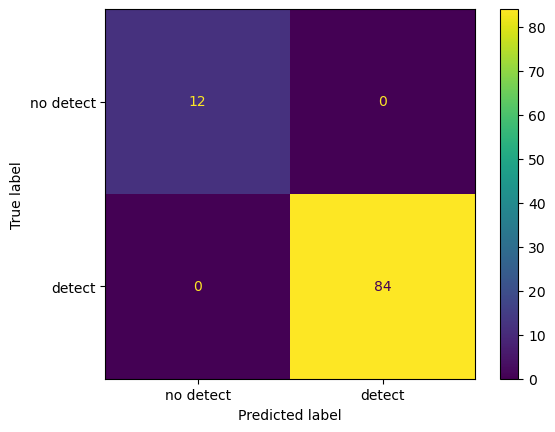

In [27]:
cm = metrics.confusion_matrix(labels_detect, predictions_detect)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no detect', 'detect'])
disp.plot()

In [28]:
predictions_bboxes = list(map(lambda p: p['bbox'] if p else None, itertools.chain.from_iterable(map(lambda image: image['predictions'], predictions))))

labels_bboxes = list(map(lambda p: p['bbox'] if p else None, itertools.chain.from_iterable(map(lambda image: image['labels'], labels))))

In [29]:
def iou_score(bbox1: List[int], bbox2: List[int]) -> float:
    ab = np.stack([np.array(bbox1), np.array(bbox2)]).astype('float32')
    intersect = np.maximum(ab[:, [2, 3]].min(axis=0) - ab[:, [0, 1]].max(axis=0), 0).prod()
    union = ((ab[:, 2] - ab[:, 0]) * (ab[:, 3] - ab[:, 1])).sum() - intersect
    return intersect / union

iou_score([0, 0, 256, 256], [256//4, 256//4, 3*256//4, 3*256//4])

0.25

(array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  2.,  3.,  4.,
         7.,  7., 10.,  9.,  6.,  9., 12.,  6.,  4.,  2.,  0.,  0.]),
 array([0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ,
        0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92,
        0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <BarContainer object of 25 artists>)

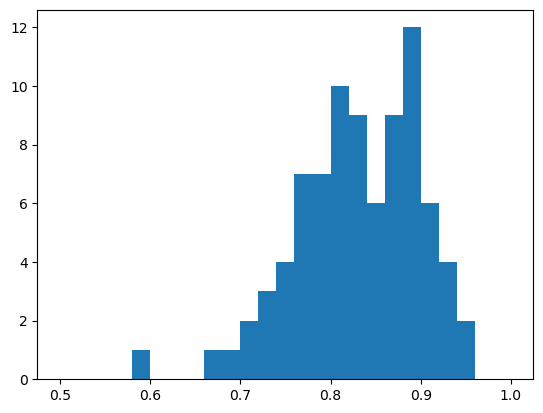

In [31]:
plt.hist(list(map(lambda bboxes: iou_score(*bboxes), filter(lambda bboxes: all(bboxes), zip(labels_bboxes, predictions_bboxes)))),
        range=(0.5, 1.0),
        bins=25)

In [32]:
predictions_gender = list(map(lambda p: (1 if p['gender']['Man'] > p['gender']['Woman'] else 0) if p else None, itertools.chain.from_iterable(map(lambda image: image['predictions'], predictions))))

labels_gender = list(map(lambda p: (1 if p['gender'] == 'Man' else 0) if p else None, itertools.chain.from_iterable(map(lambda image: image['labels'], labels))))

In [33]:
labels_gender, predictions_gender = zip(*list(filter(lambda p: not(p[0] is None or p[1] is None), zip(labels_gender, predictions_gender))))

In [34]:
print(metrics.classification_report(labels_gender, predictions_gender, target_names=['Woman', 'Man']))

              precision    recall  f1-score   support

       Woman       0.97      0.57      0.72        49
         Man       0.62      0.97      0.76        35

    accuracy                           0.74        84
   macro avg       0.79      0.77      0.74        84
weighted avg       0.82      0.74      0.73        84



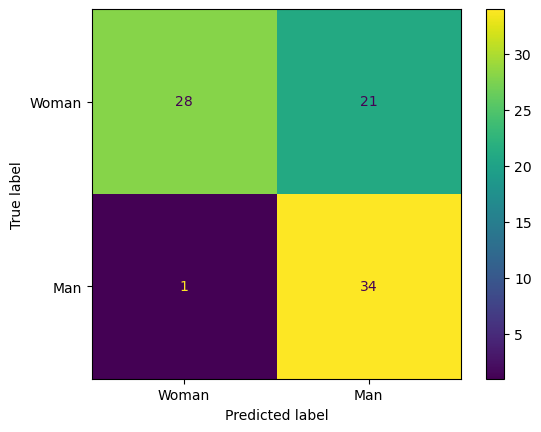

In [35]:
cm = metrics.confusion_matrix(labels_gender, predictions_gender)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Woman', 'Man'])
disp.plot()